In [1]:
from google.colab import drive
drive.mount('/content/drive')
# best
# Download the data.
!unzip /content/drive/MyDrive/SMAI.zip -d /content/SMAI

Streaming output truncated to the last 5000 lines.
  inflating: /content/SMAI/content/faces_dataset/train/image_5499.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_55.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_550.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5500.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5501.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5502.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5503.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5504.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5505.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5506.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5507.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5508.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5509.jpg  
  inflating: /co

In [2]:
import numpy as np
import pandas as pd
from glob import glob
from os.path import join
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import torch.optim as optim

from torchvision.transforms import RandomRotation, RandomHorizontalFlip, RandomResizedCrop,GaussianBlur
# yes

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

class AgeDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, annot_path, train=True):
        super(AgeDataset, self).__init__()

        self.annot_path = annot_path
        self.data_path = data_path
        self.train = train

        self.ann = pd.read_csv(annot_path)
        if train:
            # Calculate the frequency of each age
            age_counts = self.ann['age'].value_counts()

            # Sort the age counts in descending order
            sorted_age_counts = age_counts.sort_values(ascending=False)

            # Take the maximum 70 values
            max_70_values = sorted_age_counts.head(70)

            # Calculate the mean of these values
            threshold = int(max_70_values.mean())

            # Define oversampling strategy
            over = RandomOverSampler(sampling_strategy={age: threshold for age in age_counts[age_counts < threshold].index})

            # Fit and apply the transform
            self.ann, _ = over.fit_resample(self.ann, self.ann['age'])

            # Define undersampling strategy
            under = RandomUnderSampler(sampling_strategy={age: threshold for age in age_counts[age_counts > 2*threshold].index})

            # Fit and apply the transform
            self.ann, _ = under.fit_resample(self.ann, self.ann['age'])

            # Reset the index after adding rows
            self.ann.reset_index(drop=True, inplace=True)

        self.files = self.ann['file_id']
        if train:
            self.ages = self.ann['age']
        self.transform = self._transform(224)

    @staticmethod
    def _convert_image_to_rgb(image):
        return image.convert("RGB")


    def _transform(self, n_px):
        if self.train:
            # Data augmentation for training
            transform = Compose([
                RandomRotation(degrees=15),
                RandomResizedCrop(size=n_px,
                                  scale=(0.8, 1.0)),
                RandomHorizontalFlip(),
                Resize(n_px),
                GaussianBlur(kernel_size=3),
                self._convert_image_to_rgb,
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
            ])
        else:
            # Validation/test transformation
            transform = Compose([
                Resize(n_px),
                self._convert_image_to_rgb,
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
            ])
        return transform

    def read_img(self, file_name):
        im_path = join(self.data_path, file_name)
        img = Image.open(im_path)
        img = self.transform(img)
        return img

    def __getitem__(self, index):
        file_name = self.files[index]
        img = self.read_img(file_name)
        if self.train:
            age = self.ages[index]
            return img, age
        else:
            return img

    def __len__(self):
        return len(self.files)

train_path = '/content/SMAI/content/faces_dataset/train'
train_ann = '/content/SMAI/content/faces_dataset/train.csv'
train_dataset = AgeDataset(train_path, train_ann, train=True)


test_path = '/content/SMAI/content/faces_dataset/test'
test_ann = '/content/SMAI/content/faces_dataset/submission.csv'
test_dataset = AgeDataset(test_path, test_ann, train=False)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
train_indices, val_indices = train_test_split(list(range(len(train_dataset))), test_size=0.2, random_state=42)
# Create training and validation samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Create data loaders for training and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=val_sampler)

In [3]:
print(len(train_dataset))

24951


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
def predict_test(loader, model):
    model.eval()
    predictions = []

    for img in tqdm(loader):
        img = img.to(device)
        pred = model(img)
        predictions.extend(pred.flatten().detach().tolist())

    return predictions


In [6]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch

# Load pre-trained ResNet-50 model
model = models.wide_resnet50_2( weights='Wide_ResNet50_2_Weights.DEFAULT')

# Unfreeze additional layers for fine-tuning
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:  # Unfreeze layers
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modify the last layer for age detection task
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),          # Add dropout layer
    nn.Linear(num_ftrs, 1024),  # Add additional fully connected layer
    nn.ReLU(),
    nn.Dropout(0.3),           # Add dropout layer
    nn.Linear(1024, 1)          # Output 1 value for age prediction
)

# Define loss function and optimizer
criterion = nn.MSELoss()

optimizer = optim.NAdam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Use a different learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decrease learning rate every 5 epochs

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-9ba9bcbe.pth
100%|██████████| 263M/263M [00:01<00:00, 149MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

90


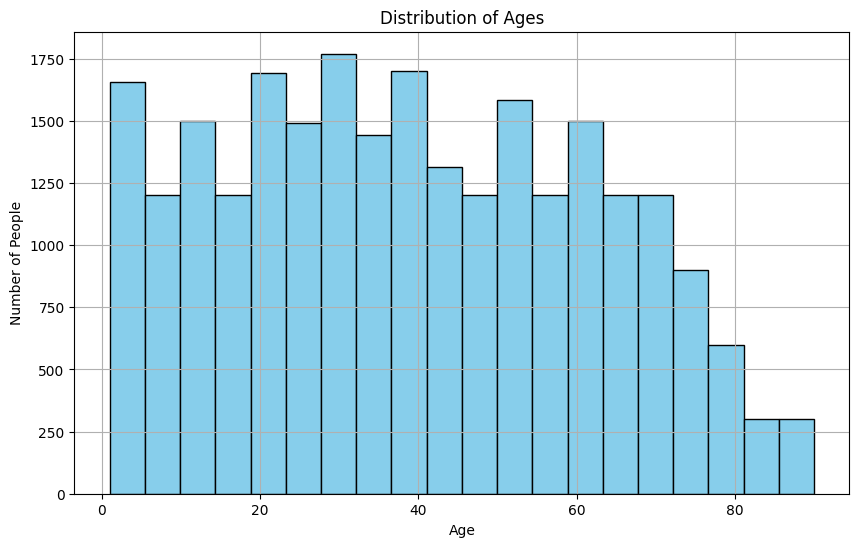

In [7]:
import matplotlib.pyplot as plt

# Extract ages from the training dataset
ages = train_dataset.ages
print(max(ages))
# Plot the distribution of ages
plt.figure(figsize=(10, 6))
plt.hist(ages, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.grid(True)
plt.show()


In [8]:
# Early stopping details
n_epochs_stop = 3
min_val_loss = float('inf')
epochs_no_improve = 0

# Training loop
num_epochs = 12 # Increase epochs to 20
best_model_path='model'
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs.squeeze(), labels.float()).item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")

    # Step the scheduler
    scheduler.step()

    # Early stopping
    if val_loss < min_val_loss:
        epochs_no_improve = 0
        min_val_loss = val_loss
        torch.save(model,best_model_path)
    else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            break
    # Generate predictions for the test set
    test_predictions = predict_test(test_loader, model)
    print(test_predictions[:50])



Epoch [1/12], Training Loss: 135.5485
Validation Loss: 14.4328


100%|██████████| 31/31 [00:15<00:00,  2.04it/s]


[59.71157455444336, 39.83103561401367, 41.32757568359375, 61.41426086425781, 25.76695442199707, 25.3099422454834, 69.64252471923828, 36.188663482666016, 49.30967712402344, 59.012840270996094, 40.38705062866211, 56.68828582763672, 62.474266052246094, 31.210832595825195, 52.40587615966797, 51.43818664550781, 18.102182388305664, 71.6551284790039, 67.10726165771484, 54.368743896484375, 35.337135314941406, 60.53723907470703, 39.342105865478516, 29.39388656616211, 38.41169738769531, 33.22505569458008, 37.12262725830078, 13.354097366333008, 6.311328411102295, 28.92941665649414, 32.46900177001953, 49.86152267456055, 9.431982040405273, 3.4128050804138184, 35.26642608642578, 24.401952743530273, 26.958585739135742, 60.288246154785156, 18.858959197998047, 49.247802734375, 30.586137771606445, 24.388765335083008, 37.92135238647461, 53.597618103027344, 23.356958389282227, 49.992828369140625, 24.778600692749023, 33.922054290771484, 17.170352935791016, 42.13236999511719]
Epoch [2/12], Training Loss: 67

100%|██████████| 31/31 [00:15<00:00,  2.00it/s]


[66.11048126220703, 41.876625061035156, 41.470947265625, 47.32740783691406, 25.980581283569336, 24.46050453186035, 78.13088989257812, 39.35148620605469, 50.715518951416016, 65.31935119628906, 54.42227554321289, 59.834739685058594, 70.88482666015625, 33.64892578125, 54.38959503173828, 50.10182571411133, 13.834742546081543, 78.75845336914062, 67.6429443359375, 53.49037170410156, 35.519996643066406, 67.72981262207031, 46.58240509033203, 33.44284439086914, 38.34419631958008, 25.730194091796875, 23.773128509521484, 7.597055435180664, 2.0808539390563965, 32.95716094970703, 34.37220001220703, 54.714210510253906, 8.422119140625, 3.112814426422119, 28.27513313293457, 27.71050453186035, 30.972620010375977, 56.47909164428711, 8.650009155273438, 46.61544418334961, 19.114282608032227, 30.57887840270996, 37.74703598022461, 54.55009460449219, 19.869977951049805, 48.09392547607422, 27.36008071899414, 28.071720123291016, 13.869049072265625, 42.04764938354492]
Epoch [3/12], Training Loss: 54.8895
Valida

100%|██████████| 31/31 [00:15<00:00,  2.04it/s]


[64.20263671875, 45.93297576904297, 34.71998977661133, 61.62098693847656, 23.506975173950195, 23.447175979614258, 85.16712188720703, 37.542598724365234, 53.952945709228516, 70.57852172851562, 50.68906021118164, 57.26173782348633, 72.09685516357422, 32.35298538208008, 56.66770553588867, 50.5092887878418, 13.230232238769531, 87.3075942993164, 74.42823028564453, 57.45371627807617, 33.34468078613281, 63.2443733215332, 37.85466384887695, 26.045551300048828, 41.462215423583984, 26.050596237182617, 38.01344680786133, 12.806930541992188, 6.0645270347595215, 30.972614288330078, 36.356468200683594, 61.09030532836914, 15.261619567871094, 4.681725978851318, 31.260608673095703, 27.861146926879883, 28.28040885925293, 66.7813491821289, 5.676253318786621, 52.66651153564453, 29.87557601928711, 26.934701919555664, 44.955989837646484, 57.04416275024414, 25.252538681030273, 48.53431701660156, 26.277896881103516, 21.173460006713867, 18.274633407592773, 40.684776306152344]
Epoch [4/12], Training Loss: 48.15

100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


[52.08124542236328, 35.743595123291016, 26.22214698791504, 53.22700500488281, 15.293540000915527, 19.061765670776367, 69.34600067138672, 33.638267517089844, 44.0315055847168, 55.9155158996582, 48.60984420776367, 51.21139907836914, 57.08441925048828, 22.915708541870117, 50.62785720825195, 41.4835319519043, 11.998981475830078, 75.58595275878906, 67.6958999633789, 50.1882438659668, 27.688798904418945, 51.765201568603516, 28.799654006958008, 22.714773178100586, 37.92021560668945, 24.504512786865234, 27.757837295532227, 7.131927013397217, 3.232968330383301, 22.61041259765625, 30.88689422607422, 57.888916015625, 9.891590118408203, 2.9529881477355957, 21.232919692993164, 22.43854331970215, 26.197542190551758, 59.239315032958984, 6.732773303985596, 44.13345718383789, 21.423261642456055, 24.67913246154785, 34.824920654296875, 39.094032287597656, 21.171533584594727, 42.925350189208984, 23.83022689819336, 15.030584335327148, 11.366147994995117, 38.58198165893555]
Epoch [5/12], Training Loss: 45.3

100%|██████████| 31/31 [00:15<00:00,  2.04it/s]


[64.30886840820312, 47.86819076538086, 39.02745819091797, 65.65280151367188, 25.907930374145508, 22.592689514160156, 81.50675964355469, 29.009445190429688, 55.67939376831055, 69.84722137451172, 52.386165618896484, 69.23771667480469, 69.7683334350586, 29.484525680541992, 54.68781661987305, 52.78969955444336, 12.637617111206055, 90.32972717285156, 79.10415649414062, 61.264976501464844, 32.649024963378906, 67.97323608398438, 46.991424560546875, 34.51572036743164, 44.437294006347656, 30.338829040527344, 35.411521911621094, 11.631723403930664, 7.132421493530273, 29.520605087280273, 30.150100708007812, 61.344871520996094, 12.431249618530273, 5.139058589935303, 24.663402557373047, 26.752073287963867, 41.80327224731445, 69.58865356445312, 7.4598259925842285, 64.70700073242188, 25.936996459960938, 30.10677146911621, 45.93857955932617, 61.818973541259766, 27.455717086791992, 50.520206451416016, 27.59404754638672, 21.03165054321289, 23.74889373779297, 44.56686782836914]
Epoch [6/12], Training Los

100%|██████████| 31/31 [00:15<00:00,  2.04it/s]


[60.29747009277344, 46.36456298828125, 39.821754455566406, 63.19141387939453, 21.707035064697266, 23.966514587402344, 77.804443359375, 30.285192489624023, 52.548614501953125, 68.19086456298828, 46.654510498046875, 63.70388412475586, 66.93428802490234, 34.73166275024414, 54.61948013305664, 49.50950622558594, 16.128782272338867, 84.103271484375, 74.88092803955078, 53.98975372314453, 33.18860626220703, 65.27666473388672, 40.733551025390625, 30.62637710571289, 43.311729431152344, 29.31532096862793, 36.43524169921875, 9.279810905456543, 4.116177558898926, 28.525880813598633, 32.73408126831055, 61.35699462890625, 12.459664344787598, 3.571053981781006, 23.778860092163086, 26.219722747802734, 36.745872497558594, 63.471580505371094, 5.532835483551025, 58.77653884887695, 29.149499893188477, 27.842012405395508, 45.946590423583984, 53.524269104003906, 24.711767196655273, 49.931819915771484, 26.631975173950195, 22.048757553100586, 20.820039749145508, 41.444332122802734]
Epoch [7/12], Training Loss:

100%|██████████| 31/31 [00:15<00:00,  2.01it/s]


[60.802207946777344, 46.34785842895508, 39.51872253417969, 62.987770080566406, 20.696016311645508, 23.452739715576172, 77.94561004638672, 30.08104133605957, 53.09452438354492, 67.95864868164062, 46.862483978271484, 63.11396789550781, 67.40721130371094, 35.13090133666992, 51.03814697265625, 47.05746078491211, 13.227311134338379, 84.10981750488281, 74.15972900390625, 52.95477294921875, 33.26264953613281, 64.54167175292969, 40.83232116699219, 29.327512741088867, 41.39641571044922, 29.441503524780273, 33.01250076293945, 9.694601058959961, 4.305526256561279, 28.543880462646484, 32.344730377197266, 62.3570442199707, 12.15289306640625, 3.8387720584869385, 24.17304229736328, 25.160818099975586, 35.627227783203125, 64.80806732177734, 5.548190116882324, 57.375221252441406, 29.708345413208008, 28.049467086791992, 44.719635009765625, 53.97396469116211, 22.859281539916992, 47.541709899902344, 25.545316696166992, 21.308263778686523, 20.68235969543457, 39.798789978027344]
Epoch [8/12], Training Loss:

100%|██████████| 31/31 [00:15<00:00,  2.01it/s]


[58.64037322998047, 44.5846061706543, 37.5638313293457, 60.09834671020508, 20.04775047302246, 24.127687454223633, 75.67019653320312, 31.764589309692383, 50.43366622924805, 65.60079956054688, 50.24495315551758, 60.71699523925781, 65.646240234375, 32.45502853393555, 51.19312286376953, 44.19412612915039, 13.665781021118164, 80.95214080810547, 73.13177490234375, 52.9572868347168, 32.58625411987305, 61.87582015991211, 40.2815055847168, 29.44379234313965, 41.85956954956055, 29.030183792114258, 31.958858489990234, 9.148628234863281, 3.365415573120117, 30.074914932250977, 32.92147445678711, 61.634490966796875, 11.723115921020508, 3.945716619491577, 23.741655349731445, 25.644346237182617, 35.92108917236328, 63.208290100097656, 4.329013824462891, 53.684242248535156, 32.17702865600586, 26.502941131591797, 45.55207443237305, 51.82925033569336, 23.954679489135742, 45.59415817260742, 26.37687110900879, 20.86188507080078, 21.543956756591797, 37.068450927734375]
Epoch [9/12], Training Loss: 21.7966
Va

100%|██████████| 31/31 [00:15<00:00,  2.01it/s]


[60.80156326293945, 44.61290740966797, 38.43256759643555, 60.678016662597656, 19.20765495300293, 23.541934967041016, 77.2073974609375, 31.42730140686035, 52.504730224609375, 66.93321228027344, 44.66886901855469, 62.46478271484375, 67.08429718017578, 31.734312057495117, 52.32836151123047, 46.882057189941406, 13.90234375, 82.9005355834961, 75.39530944824219, 54.024208068847656, 34.20758056640625, 62.80302810668945, 37.50672912597656, 28.763307571411133, 42.122406005859375, 28.79389762878418, 32.541507720947266, 8.336564064025879, 3.733767509460449, 29.199851989746094, 33.46689987182617, 62.474185943603516, 11.594096183776855, 4.1307148933410645, 25.24669647216797, 25.636629104614258, 33.291358947753906, 63.919761657714844, 4.685553550720215, 53.50238037109375, 30.99100685119629, 26.095014572143555, 46.084693908691406, 51.87562561035156, 23.214086532592773, 47.74188995361328, 24.386240005493164, 20.596784591674805, 19.656705856323242, 38.944435119628906]
Epoch [10/12], Training Loss: 20.4

100%|██████████| 31/31 [00:15<00:00,  2.05it/s]


[63.02259063720703, 45.35274124145508, 38.879920959472656, 59.55568313598633, 19.8352108001709, 25.94742202758789, 75.98179626464844, 32.0850830078125, 53.182865142822266, 67.22310638427734, 44.398948669433594, 61.9481201171875, 64.68806457519531, 32.321712493896484, 51.38581466674805, 46.074668884277344, 12.016068458557129, 83.20503997802734, 74.10033416748047, 52.81108474731445, 33.8824348449707, 63.1283073425293, 36.7437629699707, 27.7215518951416, 41.640769958496094, 30.241405487060547, 31.101070404052734, 8.614537239074707, 3.261178731918335, 29.425992965698242, 33.85945510864258, 61.162960052490234, 11.926413536071777, 4.431222915649414, 25.091346740722656, 24.636016845703125, 32.034149169921875, 64.23816680908203, 4.087052822113037, 53.589481353759766, 28.727649688720703, 27.051807403564453, 45.45651626586914, 54.569358825683594, 23.579261779785156, 44.27570343017578, 25.202478408813477, 21.324007034301758, 20.21584701538086, 37.99602508544922]
Epoch [11/12], Training Loss: 18.3

100%|██████████| 31/31 [00:15<00:00,  2.06it/s]


[61.6948127746582, 44.20688247680664, 39.162879943847656, 59.29220962524414, 19.402189254760742, 25.434804916381836, 75.44404602050781, 33.04872131347656, 52.89534378051758, 67.18585205078125, 45.608245849609375, 61.09116744995117, 64.80168151855469, 31.340641021728516, 50.9977912902832, 46.411502838134766, 12.030941009521484, 82.73214721679688, 73.79791259765625, 52.1560173034668, 34.025691986083984, 62.97267532348633, 37.69198989868164, 27.897342681884766, 40.48643493652344, 29.272785186767578, 31.048734664916992, 8.408531188964844, 3.083113670349121, 29.045150756835938, 33.092899322509766, 60.91145324707031, 11.934812545776367, 4.2742462158203125, 24.505374908447266, 24.634553909301758, 34.29113006591797, 63.641658782958984, 3.8365728855133057, 51.98868179321289, 29.079463958740234, 26.943782806396484, 44.6352424621582, 52.90696716308594, 23.224828720092773, 44.58741760253906, 24.987668991088867, 20.750289916992188, 19.524545669555664, 37.26015853881836]
Epoch [12/12], Training Loss

100%|██████████| 31/31 [00:15<00:00,  2.00it/s]

[61.93589782714844, 44.03036117553711, 37.69785690307617, 59.77640914916992, 19.1216983795166, 25.205158233642578, 75.92515563964844, 32.85491180419922, 52.727298736572266, 66.86701965332031, 46.18991470336914, 61.26572036743164, 64.73347473144531, 31.879247665405273, 51.3528938293457, 46.0344123840332, 12.700719833374023, 82.88064575195312, 73.58341979980469, 51.354835510253906, 33.03115463256836, 62.0102653503418, 37.38616943359375, 27.418031692504883, 40.38319778442383, 29.040796279907227, 30.954195022583008, 8.147141456604004, 2.8925259113311768, 28.930871963500977, 32.860103607177734, 61.281944274902344, 11.749208450317383, 3.9788198471069336, 24.786102294921875, 24.19022560119629, 33.84891128540039, 64.09559631347656, 3.566601276397705, 51.90663146972656, 28.474449157714844, 26.5870304107666, 44.623905181884766, 51.879940032958984, 23.091096878051758, 44.23501205444336, 24.867536544799805, 20.53110122680664, 19.579666137695312, 37.24300765991211]


In [ ]:
# Early stopping details
n_epochs_stop = 2
min_val_loss = float('inf')
epochs_no_improve = 0

# Training loop
num_epochs = 5 # Increase epochs to 20
best_model_path='model'
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs.squeeze(), labels.float()).item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")

    # Step the scheduler
    scheduler.step()

    # Early stopping
    if val_loss < min_val_loss:
        epochs_no_improve = 0
        min_val_loss = val_loss
        torch.save(model,best_model_path)
    else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            break
    # Generate predictions for the test set
    test_predictions = predict_test(test_loader, model)
    print(test_predictions[:50])



In [ ]:
import pandas as pd
from tqdm import tqdm

# Function to predict ages for the test set
def predict_test(loader, model):
    model.eval()
    predictions = []

    for img in tqdm(loader):
        img = img.to(device)
        pred = model(img)
        predictions.extend(pred.flatten().detach().tolist())

    return predictions

# Generate predictions for the test set
test_predictions = predict_test(test_loader, model)

# Round predictions to nearest integer
rounded_predictions = [round(pred) for pred in test_predictions]

# Load the submission file template
submission_template = pd.read_csv('/content/SMAI/content/faces_dataset/submission.csv')

# Update the age column with predictions
submission_template['age'] = rounded_predictions

# Save the submission file
submission_template.to_csv('submission.csv', index=False)

In [ ]:
print(test_predictions)